# ENRON Person of Interest Identifier
by Fernando Maletski

## Introduction

The famous ENRON scandal was the largest bankruptcy reorganization in the United States at the time it was publicized, October 2001. Due to the Federal investigation, a significant amount of confidential information was released to the public, including tens of thousands of emails and detailed financial data.

The objective of this project is to use this large dataset to create a machine learning model that correctly identifiers the Persons of Interest (POI) based on the data made public.

## Workspace Setup

In [1]:
import sys
import numpy as np
import pandas as pd
import pickle
import matplotlib
import operator
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.style.use('ggplot') #Set a decent style
matplotlib.rcParams['image.cmap'] = 'bwr' #Diverging colors

with open("final_project_dataset_py3.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

## EDA and Feature Engineering

In this section we will explore the dataset, explain features and clean issues, such as missing values and outliers.

In [2]:
len(sorted(data_dict.keys()))

146

There are 146 datapoints, each of them should represent a person whose records were made public, the key of this dictionary is their name in this format: LAST NAME FIRST NAME (MIDDLE INICIAL). As this is a small dataset, it is possible to check each persons name for inconsistencies:

In [3]:
persons = sorted(data_dict.keys())
for person in persons:
    print(person)

ALLEN PHILLIP K
BADUM JAMES P
BANNANTINE JAMES M
BAXTER JOHN C
BAY FRANKLIN R
BAZELIDES PHILIP J
BECK SALLY W
BELDEN TIMOTHY N
BELFER ROBERT
BERBERIAN DAVID
BERGSIEKER RICHARD P
BHATNAGAR SANJAY
BIBI PHILIPPE A
BLACHMAN JEREMY M
BLAKE JR. NORMAN P
BOWEN JR RAYMOND M
BROWN MICHAEL
BUCHANAN HAROLD G
BUTTS ROBERT H
BUY RICHARD B
CALGER CHRISTOPHER F
CARTER REBECCA C
CAUSEY RICHARD A
CHAN RONNIE
CHRISTODOULOU DIOMEDES
CLINE KENNETH W
COLWELL WESLEY
CORDES WILLIAM R
COX DAVID
CUMBERLAND MICHAEL S
DEFFNER JOSEPH M
DELAINEY DAVID W
DERRICK JR. JAMES V
DETMERING TIMOTHY J
DIETRICH JANET R
DIMICHELE RICHARD G
DODSON KEITH
DONAHUE JR JEFFREY M
DUNCAN JOHN H
DURAN WILLIAM D
ECHOLS JOHN B
ELLIOTT STEVEN
FALLON JAMES B
FASTOW ANDREW S
FITZGERALD JAY L
FOWLER PEGGY
FOY JOE
FREVERT MARK A
FUGH JOHN L
GAHN ROBERT S
GARLAND C KEVIN
GATHMANN WILLIAM D
GIBBS DANA R
GILLIS JOHN
GLISAN JR BEN F
GOLD JOSEPH
GRAMM WENDY L
GRAY RODNEY
HAEDICKE MARK E
HANNON KEVIN P
HAUG DAVID L
HAYES ROBERT E
HAYSLETT RODERIC

There are 2 problematic datapoins, TOTAL and THE TRAVEL AGENCY IN THE PARK.
While TOTAL is self explanatory and safe to be removed, THE TRAVEL AGENCY IN THE PARK is actually a company (http://www.businesstravelnews.com/More-News/Enron-s-Agency-Changes-Name-Reaffirms-Corp-Commitment).

Taking a closer look to it:

In [4]:
data_dict['THE TRAVEL AGENCY IN THE PARK']

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

With most of its features being missing and due to the fact it is not a person, much less a Person of Interest, this datapoint should be removed, along with TOTAL.

In [5]:
data_dict.pop('TOTAL')
data_dict.pop('THE TRAVEL AGENCY IN THE PARK')

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

In [6]:
len(sorted(data_dict.keys()))

144

Now the dataset has 144 person in it.

The values of the dictionary are another dictionary that follows this schema (key: value): feature: value.
Extracting the list of features:

In [7]:
feature_list = sorted(data_dict['ALLEN PHILLIP K'])
print(len(feature_list))
feature_list

21


['bonus',
 'deferral_payments',
 'deferred_income',
 'director_fees',
 'email_address',
 'exercised_stock_options',
 'expenses',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'loan_advances',
 'long_term_incentive',
 'other',
 'poi',
 'restricted_stock',
 'restricted_stock_deferred',
 'salary',
 'shared_receipt_with_poi',
 'to_messages',
 'total_payments',
 'total_stock_value']

We have 20 features and the hand coded Person of Interest (poi) label.

Testing to see if all the datapoints have the same features:

In [8]:
count = 0
for person, data in data_dict.items():
    for feature, value in data.items():
        if feature not in feature_list:
            print(person, feature)
        else:
            count += 1
total_count = len(feature_list) * len(data_dict.keys())
print('{} of {} found'.format(count, total_count))

3024 of 3024 found


This is all the features of the dataset, the structure supports a table schema. So it's possible to convert this dataset to an exploration friendly format, a pandas DataFrame:

In [9]:
df = pd.DataFrame(data_dict)
df = df.transpose()
df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
BANNANTINE JAMES M,NaN,NaN,-5104,NaN,james.bannantine@enron.com,4046157,56301,29,39,0,...,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,NaN,frank.bay@enron.com,NaN,129142,NaN,NaN,NaN,...,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014


Replacing 'NaN' string with np.NaN for compatibility with numeric methods:

In [10]:
df.replace('NaN', np.NaN, inplace=True)

To check is there is a person in the dataset with all their values missing (as the POI label is hand coded, it may not be missing):

In [111]:
checknull = df.T.isnull().sum() >= 20
checknull.any()

False

In [12]:
df[checknull].T

,LOCKHART EUGENE E
bonus,NaN
deferral_payments,NaN
deferred_income,NaN
director_fees,NaN
email_address,NaN
exercised_stock_options,NaN
expenses,NaN
from_messages,NaN
from_poi_to_this_person,NaN
from_this_person_to_poi,NaN


This datapoint has no values, with the exception of the poi label, it brings no information and should be removed.

In [13]:
df.drop('LOCKHART EUGENE E', inplace=True)
len(df)

143

The analysis will proceed with the final count of 143 persons.

Here's a print from a random person to have an idea of the information from each datapoint:

In [14]:
df.iloc[12]

bonus                                          1e+06
deferral_payments                                NaN
deferred_income                                  NaN
director_fees                                    NaN
email_address                philippe.bibi@enron.com
exercised_stock_options                  1.46573e+06
expenses                                       38559
from_messages                                     40
from_poi_to_this_person                           23
from_this_person_to_poi                            8
loan_advances                                    NaN
long_term_incentive                           369721
other                                         425688
poi                                            False
restricted_stock                              378082
restricted_stock_deferred                        NaN
salary                                        213625
shared_receipt_with_poi                         1336
to_messages                                   

An overview:

In [15]:
total_dps = len(df)
poi_dps = df.poi.sum()
print('Total Data Points: {:>3}'.format(total_dps))
print('Total POI        : {:>3}'.format(poi_dps))

Total Data Points: 143
Total POI        :  18


There is 2 classes of features, finance related and email related:

* **financial features:** ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

* **email features:** ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

In [16]:
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus',
                      'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses',
                      'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock',
                      'director_fees']

email_features = ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 
                     'from_this_person_to_poi', 'shared_receipt_with_poi']

### Email Features

In [17]:
print(email_features)

['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


#### Missing Values

In [18]:
print_list = []
for feature in email_features:
    title = feature
    count = df[feature].count()
    missing = total_dps - count
    poi_count = len(df.query(feature+' != "NaN" and poi==True'))
    pct_missing = 100*missing/total_dps
    print_list.append((title, count, missing, poi_count, pct_missing))

print('{:>30}: {:<8} {:<8} {:<10} {:<8}'.format('Title', 'Count', 'Missing', 'POI Count', '% Missing'))
for (title, count, missing, poi_count, pct_missing) in sorted(print_list, key=operator.itemgetter(4),
                                                              reverse=True):
    print('{:>30}: {:<8} {:<8} {:<10} {:<8.2f}'.format(title, count, missing, poi_count, pct_missing))

                         Title: Count    Missing  POI Count  % Missing
                   to_messages: 86       57       14         39.86   
       from_poi_to_this_person: 86       57       14         39.86   
                 from_messages: 86       57       14         39.86   
       from_this_person_to_poi: 86       57       14         39.86   
       shared_receipt_with_poi: 86       57       14         39.86   
                 email_address: 111      32       18         22.38   


There's no email feature with a relatively high amount of missing values, so they are valid.

#### New Features

The first approach we can take is to see if POIs communicate to each other a lot, using the features from_poi_to_this_person and from_this_person_to_poi:

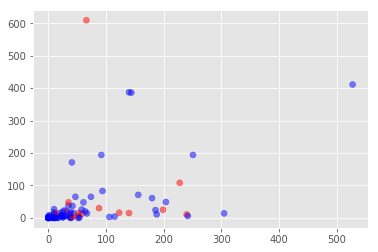

In [19]:
plt.scatter(df.from_poi_to_this_person, df.from_this_person_to_poi, c=df.poi, alpha=0.5)

It is a good idea, but there are people who sends a lot of emails and those that don't, so, engineering 2 new features, from_poi_ratio and to_poi_ratio may help:

In [20]:
df['from_poi_ratio'] = df.from_poi_to_this_person/df.to_messages
df['to_poi_ratio'] = df.from_this_person_to_poi/df.from_messages

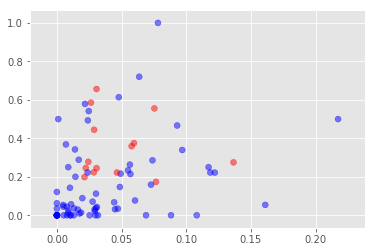

In [21]:
plt.scatter(df.from_poi_ratio, df.to_poi_ratio, c=df.poi, alpha=0.5)

Good, these features will help to filter a lot of people.

Using the same line of thought with the feature "shared_receipt_with_poi" doesn't help too much:

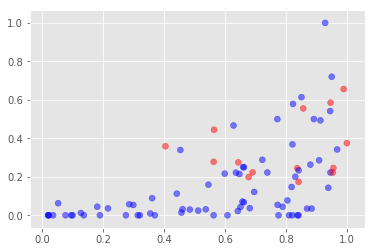

In [22]:
plt.scatter(df.shared_receipt_with_poi/df.to_messages, df.to_poi_ratio, c=df.poi, alpha=0.5)

In [23]:
selected_email_features = ['from_poi_ratio', 'to_poi_ratio']

### Financial Features

There is a lot of financial features:

In [24]:
print(financial_features)
print(len(financial_features))

['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
14


#### Missing Values

If there is features with too much missing values, they won't help with the classification.

In [25]:
print_list = []
for feature in financial_features:
    title = feature
    count = df[feature].count()
    missing = total_dps - count
    poi_count = len(df.query(feature+' != "NaN" and poi==True'))
    pct_missing = 100*missing/total_dps
    print_list.append((title, count, missing, poi_count, pct_missing))

print('{:>30}: {:<8} {:<8} {:<10} {:<8}'.format('Title', 'Count', 'Missing', 'POI Count', '% Missing'))
for (title, count, missing, poi_count, pct_missing) in sorted(print_list, key=operator.itemgetter(4),
                                                              reverse=True):
    print('{:>30}: {:<8} {:<8} {:<10} {:<8.2f}'.format(title, count, missing, poi_count, pct_missing))

                         Title: Count    Missing  POI Count  % Missing
                 loan_advances: 3        140      1          97.90   
                 director_fees: 16       127      0          88.81   
     restricted_stock_deferred: 17       126      0          88.11   
             deferral_payments: 38       105      5          73.43   
               deferred_income: 48       95       11         66.43   
           long_term_incentive: 65       78       12         54.55   
                         bonus: 81       62       16         43.36   
                         other: 91       52       18         36.36   
                        salary: 94       49       17         34.27   
                      expenses: 94       49       18         34.27   
       exercised_stock_options: 101      42       12         29.37   
              restricted_stock: 109      34       17         23.78   
                total_payments: 123      20       18         13.99   
             total_

Features with a high amount of missing values and low POI count won't be useful. Removing them:

In [26]:
features_to_remove = ['loan_advances', 'director_fees', 'restricted_stock_deferred']
for feature in features_to_remove:
    financial_features.remove(feature)
print(financial_features)
len(financial_features)

['salary', 'deferral_payments', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock']


11

#### Exploration

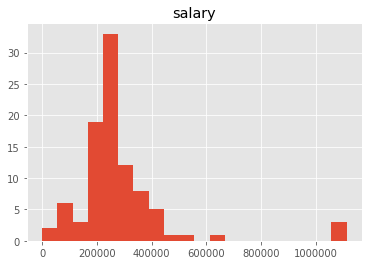

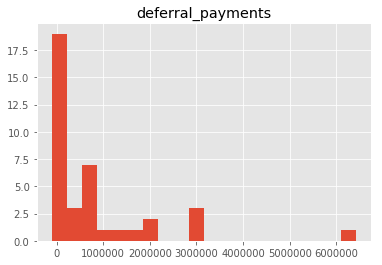

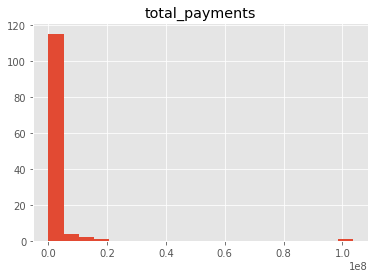

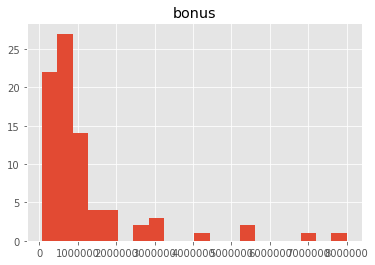

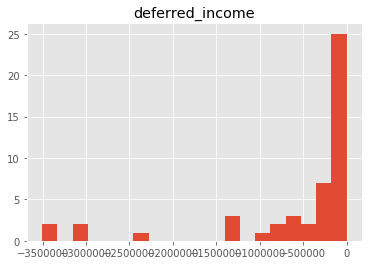

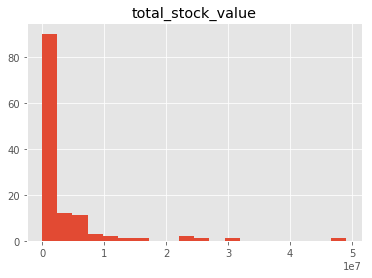

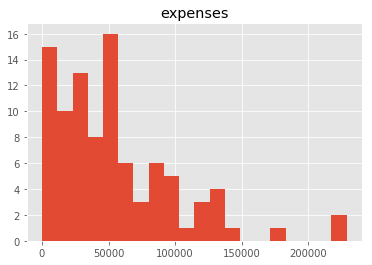

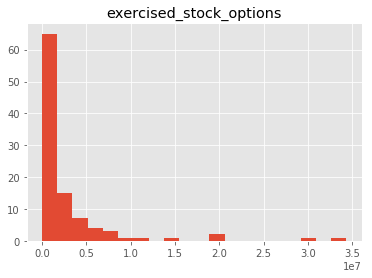

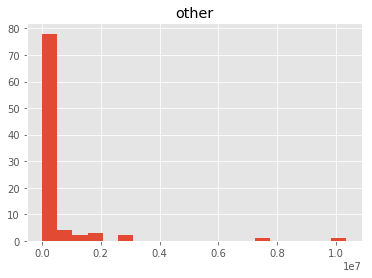

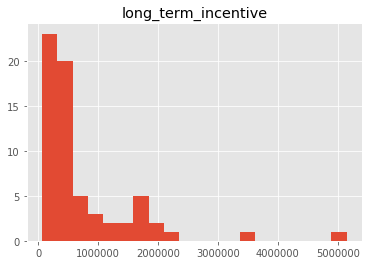

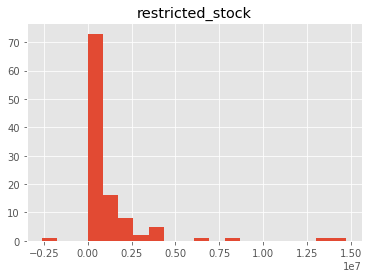

In [27]:
for feature in financial_features:
    plt.hist(df[feature].dropna(),20)
    plt.title(feature)
    plt.show()

With the exception of salary, all features are skewed. Using it as a basis for scatterplots to have an idea of the POI/non-POI distribution:

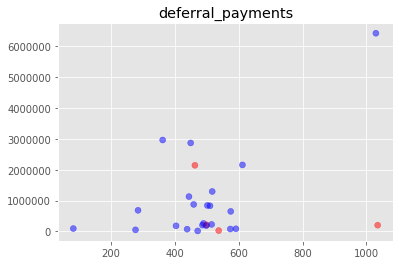

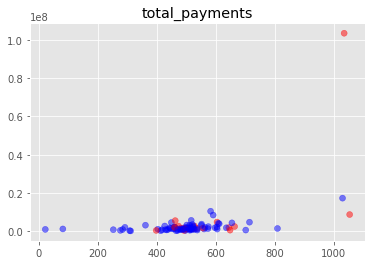

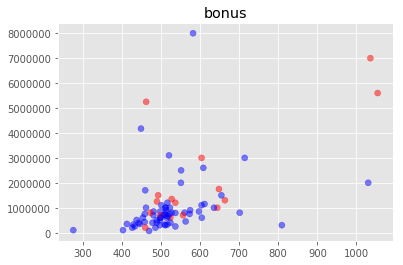

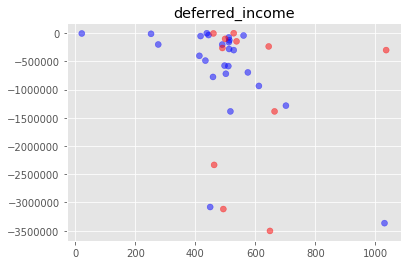

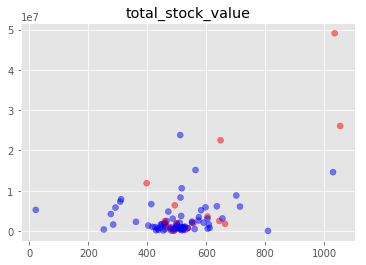

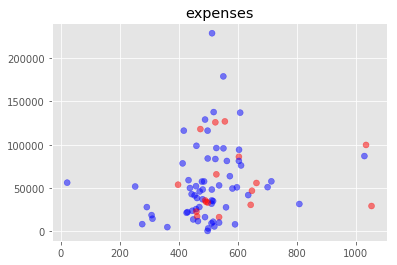

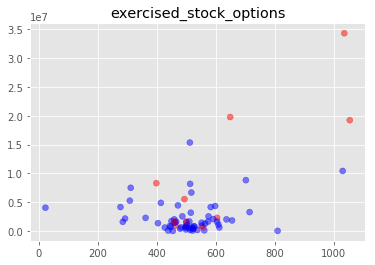

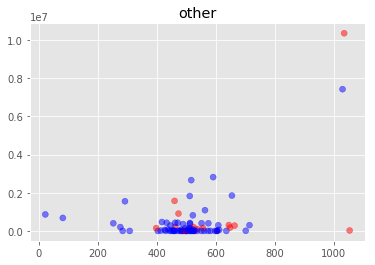

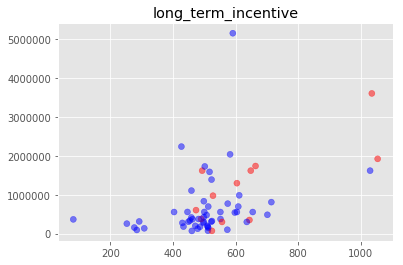

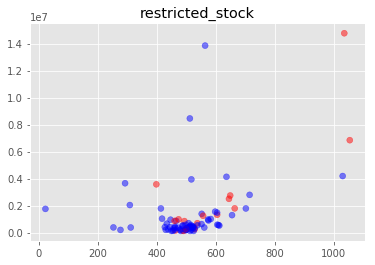

In [28]:
for feature in financial_features[1:]:
    plt.scatter(np.sqrt(df.salary), df[feature], c=df.poi, alpha=0.5)
    plt.title(feature)
    plt.show()

### Pre Selected Features

In [29]:
features = selected_email_features+financial_features
print(features)
len(features)

['from_poi_ratio', 'to_poi_ratio', 'salary', 'deferral_payments', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock']


13

### Feature Scaling and Handling of Missing Values

A few of the chosen models to test, namely SVMs, will benefit from feature scaling as the features are of varying magnitudes.

The MinMaxScaler is a simple yet effective way to bring all the features to comparable values, between 0 and 1.

From now on, missing values (NaN) will be replaced by 0.

In [30]:
df.fillna(0, inplace=True)

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,from_poi_ratio,to_poi_ratio
ALLEN PHILLIP K,0.521875,0.455199,0.120800,0.0,phillip.allen@enron.com,0.050353,0.060622,2195.0,47.0,65.0,...,False,0.157232,-126027.0,0.181735,1407.0,2902.0,0.043303,0.036083,0.074518,0.029613
BADUM JAMES P,0.000000,0.043109,1.000000,0.0,0,0.007506,0.015238,0.0,0.0,0.0,...,False,0.149975,0.0,0.000000,0.0,0.0,0.001762,0.006142,0.000000,0.000000
BANNANTINE JAMES M,0.000000,0.015698,0.998544,0.0,james.bannantine@enron.com,0.117798,0.246111,29.0,39.0,0.0,...,False,0.251180,-560222.0,0.000429,465.0,566.0,0.008847,0.107571,0.317034,0.000000
BAXTER JOHN C,0.150000,0.214142,0.604480,0.0,0,0.194494,0.048959,0.0,0.0,0.0,...,False,0.377009,0.0,0.240360,0.0,0.0,0.054407,0.217018,0.000000,0.000000
BAY FRANKLIN R,0.050000,0.055587,0.942460,0.0,frank.bay@enron.com,0.000000,0.564523,0.0,0.0,0.0,...,False,0.158370,-82782.0,0.215675,0.0,0.0,0.007992,0.002179,0.000000,0.000000


## Feature Selection

### Evaluation Metrics

The dataset is very unbalanced towards non-POI:

In [32]:
print('POI: {} | Total: {}'.format(len(df), np.sum(df.poi==True)))

POI: 143 | Total: 18


Using precision, or F1, generates warnings because a lot of the times they end up dividing by 0. Ignoring warnings for now on:

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [112]:
print('Accuracy if predicted all non-POI: {:0.6f}'.format((143-18)/143))

Accuracy if predicted all non-POI: 0.874126


Ideally, the classifier should be more accurate than 0.8759, while having high recall and precision.

Due to the imbalanced nature of the dataset (way more non-POI than POI), using just accuracy, or even F1, results in poor detection performance.

The objective here is fraud detection! A model that is accurate but doesn't detect a lot of POI is not a good one.

There is a metric specifically created to deal with highly imbalanced classes, called Matthews correlation coefficient:

The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary (two-class) classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes.[source: Wikipedia | http://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html | https://en.wikipedia.org/wiki/Matthews_correlation_coefficient]

The MCC is the chosen metric in this project for parameter tuning and evaluation.

Preparing the metrics for iteration using GridSearchCV:

In [35]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
mcc = make_scorer(matthews_corrcoef)
scorers = {'mcc': mcc, 'accuracy': 'accuracy', 'f1': 'f1', 
           'recall': 'recall', 'precision': 'precision'}

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
def print_summary(clf):
    print(clf.best_estimator_)
    mcc = clf.cv_results_['mean_test_mcc'][clf.best_index_]
    print('MCC:       {:0.4f}'.format(mcc))
    f1 =  clf.cv_results_['mean_test_f1'][clf.best_index_]
    print('F1:        {:0.4f}'.format(f1))
    pre = clf.cv_results_['mean_test_precision'][clf.best_index_]
    print('Precision: {:0.4f}'.format(pre))
    rec = clf.cv_results_['mean_test_recall'][clf.best_index_]
    print('Recall:    {:0.4f}'.format(rec))
    acc = clf.cv_results_['mean_test_accuracy'][clf.best_index_]
    print('Accuracy:  {:0.4f}'.format(acc))
    return (str(clf.best_estimator_).split('(')[0], mcc, f1, pre, rec, acc)

### Validation Strategy

With the class imbalance present in the dataset, a stratified solution of cross-validation is needed. Scikit-learn provides us with 2:

* StratifiedKFold http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
* StratifiedShuffleSplit http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

Both will preserve the percentage of samples for each class. The key difference is the splitting method.

StratifiedKFold will split the dataset k times, and use k-1 folds for training and the remaining for testing. The process is repeated k times.

StratifiedShuffleSplit will shuffle the dataset and split it n_splits times respecting to the chosen test_size.

While both are valid ways of cross validation, due to the small size of the dataset, StratifiedShuffleSplit provides less chance of overfitting.

In [38]:
from sklearn.model_selection import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=50, test_size=0.3, random_state=42)

The random state is set to 42 for test–retest reliability.

### Model Pre-Selection

As per http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html, the workflow should be:

* Linear SVC
* KN Classifier
* SVC (other kernels)
* Ensemble Classifiers
    + Random Forest
    + Adaboost

In [39]:
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

Both ensemble classifiers use Decision Trees as a base, so it makes sense to add it to the pre-selection too. Adaboost, in particular, sometimes benefits greatly from a tuned DecisionTreeClassifier as its base.

In [40]:
from sklearn.tree import DecisionTreeClassifier

### Testing methodology

To test the pre-selected models and features, a solid testing method must be chosen. 

Scikit-learn has GridSerchCV, the main function of this object is actually parameter tuning, but passing an empty dictionary as the parameters turn it into a robust testing method, that handles dataset splitting in accordance with a selected cross-validator, with the added bonus of an easy to use parallel processing, drasticaly speeding up the process.

In [41]:
from sklearn.model_selection import GridSearchCV

### Feature Selection

While exploring and selecting them by hand is a valid approach, so is using statistics to do it and testing to do it. 

This code will print the p_values and ANOVA F-scores of each feature (NaN is filled with 0):

FORMAT: p_value : feature : F-score

In [42]:
from sklearn.feature_selection import SelectKBest
selector = SelectKBest()
selector.fit(df[features], df.poi)

SelectKBest(k=10, score_func=<function f_classif at 0x7f7f96cc07b8>)

In [43]:
features_ranked = []
print('{:>30} :{:^30}: {}'.format('p_value', 'Feature', 'F-score'))
print('')
for (feature, score, pvalue) in sorted(zip(features, selector.scores_, selector.pvalues_),
                               key=operator.itemgetter(1), reverse=True):
    features_ranked.append(feature)
    print('{:>30} :{:^30}: {}'.format(pvalue, feature, score))

                       p_value :           Feature            : F-score

        1.8182048777865317e-06 :   exercised_stock_options    : 24.815079733218194
        2.4043152760437106e-06 :      total_stock_value       : 24.182898678566872
          1.10129873239521e-05 :            bonus             : 20.792252047181538
        3.4782737683651706e-05 :            salary            : 18.289684043404513
         8.388953356704216e-05 :         to_poi_ratio         : 16.40971254803579
         0.0009220367084670714 :       deferred_income        : 11.458476579280697
          0.001994181245353672 :     long_term_incentive      : 9.922186013189839
          0.002862802957909168 :       restricted_stock       : 9.212810621977086
         0.0035893261725152385 :        total_payments        : 8.772777730091681
           0.01475819996537172 :           expenses           : 6.094173310638967
          0.042581747012345836 :            other             : 4.1874775069953785
           0.079116

SelectKBest provides a good way to choose the right features for a machine learning model. However, using just univariate statistics for feature selection doesn't take into account feature interaction, the ideal k is hard to pinpoint without further testing.

Ideally, testing every single feature combination would yield the best result, but it is both time and processing power expensive to do so.

The next best thing is to rank the features as it is done above, and recursively remove the lowest ranked one to test its value.

For the testing, two classifiers will be used, the simplest SVM: LinearSVC, and the base of the ensemble classifiers: DecisionTreeClassifier. Both will be run using stock parameter for now, with the exception of: 
* class_weight='balanced' - highly beneficial for imbalanced datasets;
* and random_state=42 - for test–retest reliability.

In [44]:
def test_k(features_list, k):
    features = df[features_list[0:k]].values
    labels = df.poi.values
    parameters = {'class_weight': ['balanced'], 'random_state': [42]}
    clf1 = GridSearchCV(LinearSVC(), parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=0)
    clf1.fit(features, labels)
    mcc1 = clf1.cv_results_['mean_test_mcc'][clf1.best_index_]
    f11 =  clf1.cv_results_['mean_test_f1'][clf1.best_index_]
    pre1 = clf1.cv_results_['mean_test_precision'][clf1.best_index_]
    rec1 = clf1.cv_results_['mean_test_recall'][clf1.best_index_]
    acc1 = clf1.cv_results_['mean_test_accuracy'][clf1.best_index_]
    
    clf2 = GridSearchCV(DecisionTreeClassifier(), parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=0)
    clf2.fit(features, labels)
    mcc2 = clf2.cv_results_['mean_test_mcc'][clf2.best_index_]
    f12 =  clf2.cv_results_['mean_test_f1'][clf2.best_index_]
    pre2 = clf2.cv_results_['mean_test_precision'][clf2.best_index_]
    rec2 = clf2.cv_results_['mean_test_recall'][clf2.best_index_]
    acc2 = clf2.cv_results_['mean_test_accuracy'][clf2.best_index_]
    
    results = [features_list[k-1], k, mcc1, f11, pre1, rec1, acc1, mcc2, f12, pre2, rec2, acc2]
    return results

In [103]:
test_results = []
for k in range(1,14):
    print('Testing k={}'.format(k))
    result = test_k(features_ranked, k)
    test_results.append(result)
print('Finished')

Testing k=1
Testing k=2
Testing k=3
Testing k=4
Testing k=5
Testing k=6
Testing k=7
Testing k=8
Testing k=9
Testing k=10
Testing k=11
Testing k=12
Testing k=13
Finished


In [104]:
result = pd.DataFrame(test_results, columns=['feature added', 'k', 'svc_mcc', 'svc_f1', 'svc_pre', 'svc_rec', 'svc_acc',
                                        'dt_mcc', 'dt_f1', 'dt_pre', 'dt_rec', 'dt_acc'])
result

,feature added,k,svc_mcc,svc_f1,svc_pre,svc_rec,svc_acc,dt_mcc,dt_f1,dt_pre,dt_rec,dt_acc
0,exercised_stock_options,1,0.183206,0.275481,0.273405,0.300,0.822791,0.081012,0.203668,0.156438,0.376,0.693488
1,total_stock_value,2,0.164878,0.263342,0.249906,0.300,0.811628,0.075710,0.192084,0.177444,0.224,0.784186
2,bonus,3,0.222942,0.311139,0.295520,0.348,0.829767,0.179445,0.268247,0.274283,0.284,0.827907
3,salary,4,0.217347,0.315207,0.250460,0.452,0.782326,0.071898,0.175272,0.177601,0.184,0.807442
4,to_poi_ratio,5,0.350369,0.419058,0.317967,0.656,0.792093,0.195031,0.276283,0.281119,0.304,0.831628
5,deferred_income,6,0.320127,0.394541,0.303765,0.604,0.793488,0.153568,0.235803,0.241500,0.252,0.835349
6,long_term_incentive,7,0.303351,0.381437,0.293314,0.588,0.786977,0.133484,0.211502,0.246452,0.204,0.838605
7,restricted_stock,8,0.296001,0.375285,0.284912,0.588,0.782326,0.111067,0.195280,0.232452,0.184,0.829767
8,total_payments,9,0.296697,0.375951,0.285639,0.588,0.782791,0.095763,0.178914,0.204976,0.172,0.829302
9,expenses,10,0.265657,0.354850,0.280825,0.516,0.788837,0.170631,0.254071,0.277500,0.260,0.833488


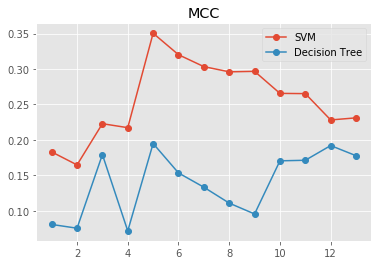

In [105]:
plt.plot(result['k'], result['svc_mcc'], 'o-', result['k'], result['dt_mcc'], 'o-')
plt.title('MCC')
plt.legend(['SVM', 'Decision Tree'])
plt.show()

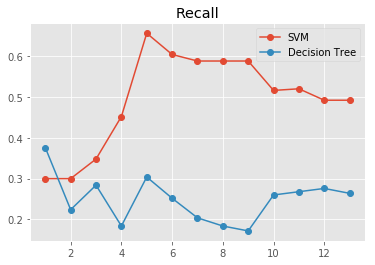

In [106]:
plt.plot(result['k'], result['svc_rec'], 'o-', result['k'], result['dt_rec'], 'o-')
plt.title('Recall')
plt.legend(['SVM', 'Decision Tree'])
plt.show()

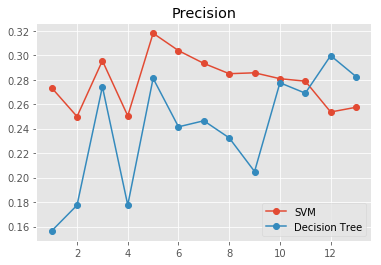

In [107]:
plt.plot(result['k'], result['svc_pre'], 'o-', result['k'], result['dt_pre'], 'o-')
plt.title('Precision')
plt.legend(['SVM', 'Decision Tree'])
plt.show()

In these plots, it becomes evident that the best value for k is 5, for both algorithms and the MCC and Recall metrics. However, there's a one interesting observations:
* The addition of features #2, #4, #6, #7, #8, #9 and (to a lesser extent) #11 appear to decrease the performance across the board (with few exceptions).

What if removing those features yields better results? 

In [50]:
hand_picked = features_ranked.copy()
j=0
for i in [1,3,5,6,7,8,10]:
    hand_picked.remove(features_ranked[i])

In [51]:
hand_picked

['exercised_stock_options',
 'bonus',
 'to_poi_ratio',
 'expenses',
 'from_poi_ratio',
 'deferral_payments']

In [52]:
test_results = []
for k in range(1,7):
    print('Testing k={}'.format(k))
    result = test_k(hand_picked, k)
    test_results.append(result)
print('Finished')

Testing k=1
Testing k=2
Testing k=3
Testing k=4
Testing k=5
Testing k=6
Finished


In [53]:
result_hp = pd.DataFrame(test_results, columns=['feature added', 'k', 'svc_mcc', 'svc_f1', 'svc_pre', 'svc_rec', 'svc_acc',
                                        'dt_mcc', 'dt_f1', 'dt_pre', 'dt_rec', 'dt_acc'])
result_hp

,feature added,k,svc_mcc,svc_f1,svc_pre,svc_rec,svc_acc,dt_mcc,dt_f1,dt_pre,dt_rec,dt_acc
0,exercised_stock_options,1,0.183206,0.275481,0.273405,0.300,0.822791,0.081012,0.203668,0.156438,0.376,0.693488
1,bonus,2,0.228897,0.314223,0.305351,0.344,0.834419,0.215937,0.295005,0.319415,0.304,0.839070
2,to_poi_ratio,3,0.326742,0.402782,0.318242,0.592,0.800465,0.252803,0.322194,0.348206,0.332,0.851628
3,expenses,4,0.304589,0.388691,0.310326,0.552,0.799535,0.254273,0.312312,0.378786,0.300,0.861860
4,from_poi_ratio,5,0.296986,0.381602,0.296099,0.568,0.787907,0.257919,0.319545,0.367786,0.312,0.860000
5,deferral_payments,6,0.280761,0.369213,0.290450,0.544,0.783721,0.297573,0.361290,0.393500,0.360,0.863721


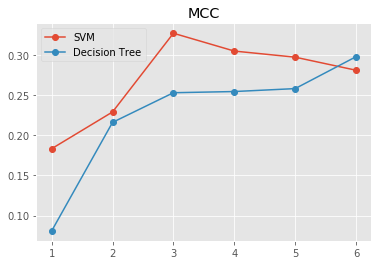

In [108]:
plt.plot(result_hp['k'], result_hp['svc_mcc'], 'o-', result_hp['k'], result_hp['dt_mcc'], 'o-')
plt.title('MCC')
plt.legend(['SVM', 'Decision Tree'])
plt.show()

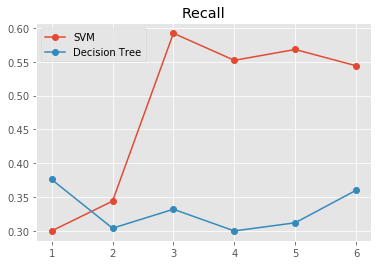

In [109]:
plt.plot(result_hp['k'], result_hp['svc_rec'], 'o-', result_hp['k'], result_hp['dt_rec'], 'o-')
plt.title('Recall')
plt.legend(['SVM', 'Decision Tree'])
plt.show()

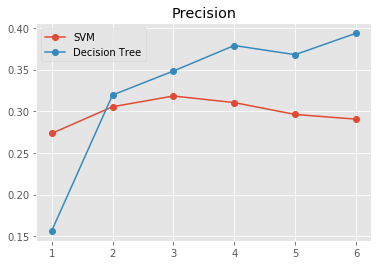

In [110]:
plt.plot(result_hp['k'], result_hp['svc_pre'], 'o-', result_hp['k'], result_hp['dt_pre'], 'o-')
plt.title('Precision')
plt.legend(['SVM', 'Decision Tree'])
plt.show()

This approach was extremely beneficial for the Decision Tree algorithm. The SVC suffered a bit, but not enough to not use the hand picked features for the rest of the project.

In [57]:
selector = SelectKBest(k=6)
filtered = selector.fit_transform(df[hand_picked], df.poi)
selected_features = []
for (feature, selected) in zip(hand_picked, selector.get_support()):
    if selected:
        selected_features.append(feature)

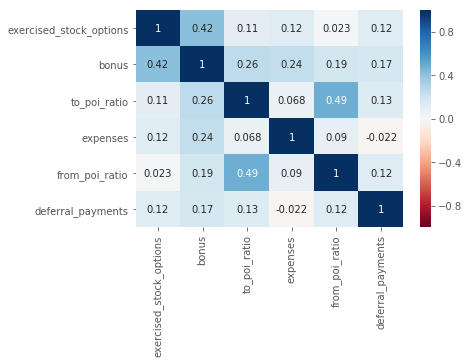

In [58]:
selected = pd.DataFrame(filtered, columns = selected_features)
corr = selected.corr()
sns.heatmap(corr, xticklabels=corr.columns,
            yticklabels=corr.columns, cmap='RdBu', 
            vmin = -1.0, vmax = 1.0, annot = True)

In [59]:
features = df[hand_picked].values
labels = df.poi.values

## Model Selection

Everything is in order to start the tests. Each model will be run in 3 times (2 if the model has already reached its best performance):
* First run: General range of parameters of different magnitudes
* Second run: Specific parameter range
* Third run: Fine tuning

Afterwards a summary of findings is presented.

### Linear SVM Classifier

#### First run

In [60]:
parameters = {'C': [1,2,3,5,10,15,20,50,100,200,300,400,500,1000,2500,5000,10000],
              'class_weight': [None, 'balanced']}
bclf = LinearSVC(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 50 folds for each of 34 candidates, totalling 1700 fits


[Parallel(n_jobs=10)]: Done 220 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 1700 out of 1700 | elapsed:    1.8s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=42, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'C': [1, 2, 3, 5, 10, 15, 20, 50, 100, 200, 300, 400, 500, 1000, 2500, 5000, 10000], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision'},
       verbose=1)

In [61]:
lsvm = print_summary(clf)

LinearSVC(C=200, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)
MCC:       0.3045
F1:        0.3827
Precision: 0.3649
Recall:    0.4720
Accuracy:  0.8181


#### Second run

In [62]:
parameters = {'C': [100,110,120,130,140,150,160,170,180,190,200,
                    210,220,230,240,250,260,270,280,290,300],
              'class_weight': [None, 'balanced']}
bclf = LinearSVC(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 50 folds for each of 42 candidates, totalling 2100 fits


[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 2100 out of 2100 | elapsed:    2.3s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=42, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'C': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision'},
       verbose=1)

In [63]:
lsvm = print_summary(clf)

LinearSVC(C=270, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)
MCC:       0.3185
F1:        0.3863
Precision: 0.3890
Recall:    0.4440
Accuracy:  0.8400


#### Third run

In [64]:
parameters = {'C': [260,261,262,263,264,265,266,267,268,269,270,
                    271,272,273,274,275,276,277,278,279,280],
              'class_weight': [None, 'balanced']}
bclf = LinearSVC(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 50 folds for each of 42 candidates, totalling 2100 fits


[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 2100 out of 2100 | elapsed:    2.3s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=42, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'C': [260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision'},
       verbose=1)

In [65]:
lsvm = print_summary(clf)

LinearSVC(C=269, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)
MCC:       0.3242
F1:        0.3897
Precision: 0.3931
Recall:    0.4600
Accuracy:  0.8349


#### Summary

This model is limited, even tuning the parameters to a wide range of values can't increase it's performance to an acceptable level.

### KNeighbors Classifier

#### First run

In [66]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'weights': ['uniform', 'distance'],
              'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [1,2,5,10,20,30,40,50],
              'p': [1,2]
             }
bclf = KNeighborsClassifier()
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 50 folds for each of 960 candidates, totalling 48000 fits


[Parallel(n_jobs=10)]: Done 200 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 2900 tasks      | elapsed:    4.1s
[Parallel(n_jobs=10)]: Done 7400 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done 13700 tasks      | elapsed:   17.9s
[Parallel(n_jobs=10)]: Done 21800 tasks      | elapsed:   29.7s
[Parallel(n_jobs=10)]: Done 31700 tasks      | elapsed:   42.3s
[Parallel(n_jobs=10)]: Done 43400 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 48000 out of 48000 | elapsed:  1.3min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=42, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'leaf_size': [1, 2, 5, 10, 20, 30, 40, 50], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision'},
       verbose=1)

In [67]:
knc = print_summary(clf)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')
MCC:       0.2595
F1:        0.2798
Precision: 0.4807
Recall:    0.2120
Accuracy:  0.8823


#### Second run

In [68]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5],
              'weights': ['distance'],
              'algorithm' : ['ball_tree'],
              'leaf_size': [1,2,3,4,5,6,7,8,9,10],
              'p': [1,2]
             }
bclf = KNeighborsClassifier()
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 50 folds for each of 100 candidates, totalling 5000 fits


[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 5000 out of 5000 | elapsed:    6.6s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=42, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5], 'weights': ['distance'], 'algorithm': ['ball_tree'], 'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision'},
       verbose=1)

In [69]:
knc = print_summary(clf)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')
MCC:       0.2595
F1:        0.2798
Precision: 0.4807
Recall:    0.2120
Accuracy:  0.8823


#### Summary

While it achieved a higher accuracy, it came with the cost of much lower recall. The relatively good precision might be an asset.

### SVM Classifier (other kernels)

#### First run

In [70]:
parameters = {'kernel': ['poly', 'rbf', 'sigmoid'],
              'C': [1,2,3,5,10,15,20,50,100,200,300,400,500,1000,2500,5000,10000],
              'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 25, 50],
              'class_weight': [None, 'balanced']}
bclf = SVC(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 50 folds for each of 816 candidates, totalling 40800 fits


[Parallel(n_jobs=10)]: Done 200 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 7380 tasks      | elapsed:    7.1s
[Parallel(n_jobs=10)]: Done 19880 tasks      | elapsed:   18.5s
[Parallel(n_jobs=10)]: Done 37380 tasks      | elapsed:   34.8s
[Parallel(n_jobs=10)]: Done 40800 out of 40800 | elapsed:   37.8s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=42, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'kernel': ['poly', 'rbf', 'sigmoid'], 'C': [1, 2, 3, 5, 10, 15, 20, 50, 100, 200, 300, 400, 500, 1000, 2500, 5000, 10000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 25, 50], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision'},
       verbose=1)

In [71]:
svm = print_summary(clf)

SVC(C=15, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='poly',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
MCC:       0.3421
F1:        0.4107
Precision: 0.4054
Recall:    0.4600
Accuracy:  0.8521


#### Second run

In [72]:
parameters = {'kernel': ['poly', 'rbf', 'sigmoid'],
              'C': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
              'gamma': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
                        21,22,23,24,25,26,27,28,29,30],
              'class_weight': ['balanced']}
bclf = SVC(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 50 folds for each of 1440 candidates, totalling 72000 fits


[Parallel(n_jobs=10)]: Done 220 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 6300 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done 16800 tasks      | elapsed:   16.3s
[Parallel(n_jobs=10)]: Done 31500 tasks      | elapsed:   30.7s
[Parallel(n_jobs=10)]: Done 50400 tasks      | elapsed:   48.8s
[Parallel(n_jobs=10)]: Done 72000 out of 72000 | elapsed:  1.2min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=42, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'kernel': ['poly', 'rbf', 'sigmoid'], 'C': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'gamma': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision'},
       verbose=1)

In [73]:
svm = print_summary(clf)

SVC(C=6, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=3, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
MCC:       0.3540
F1:        0.4022
Precision: 0.2679
Recall:    0.8280
Accuracy:  0.7140


#### Third run 

In [74]:
parameters = {'kernel': ['sigmoid'],
              'C': [5.1,5.2,5.3,5.4,5.5,5.6,5.7,5.8,5.9,6,
                    6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7],
              'gamma': [2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,
                        3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4],
              'class_weight': ['balanced']}
bclf = SVC(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 50 folds for each of 400 candidates, totalling 20000 fits


[Parallel(n_jobs=10)]: Done 200 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 6820 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done 18320 tasks      | elapsed:   17.0s
[Parallel(n_jobs=10)]: Done 20000 out of 20000 | elapsed:   18.4s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=42, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'kernel': ['sigmoid'], 'C': [5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7], 'gamma': [2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision'},
       verbose=1)

In [75]:
svm = print_summary(clf)

SVC(C=5.4, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=3.9, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
MCC:       0.3776
F1:        0.4163
Precision: 0.2766
Recall:    0.8680
Accuracy:  0.7149


#### Summary

This model was able to get a high recall score. However, it came with the price of lower accuracy and abysmal precision.

### Decision Trees

#### First run

In [76]:
parameters = {'criterion': ['gini', 'entropy'],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'min_samples_leaf': [1,2,5,10,15,20,30],
              'class_weight': [None, 'balanced']}
bclf = DecisionTreeClassifier(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 50 folds for each of 112 candidates, totalling 5600 fits


[Parallel(n_jobs=10)]: Done 240 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 3540 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done 5600 out of 5600 | elapsed:    4.1s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=42, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2', None], 'min_samples_leaf': [1, 2, 5, 10, 15, 20, 30], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision'},
       verbose=1)

In [77]:
dt = print_summary(clf)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
MCC:       0.4682
F1:        0.5258
Precision: 0.4432
Recall:    0.6960
Accuracy:  0.8428


#### Second run

In [78]:
parameters = {'criterion': ['gini', 'entropy'],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'min_samples_leaf': [15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                                   31,32,33,34,35,36,37,38,39,40],
              'class_weight': [None, 'balanced']}
bclf = DecisionTreeClassifier(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 50 folds for each of 416 candidates, totalling 20800 fits


[Parallel(n_jobs=10)]: Done 240 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 3540 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done 9040 tasks      | elapsed:    6.6s
[Parallel(n_jobs=10)]: Done 16740 tasks      | elapsed:   12.2s
[Parallel(n_jobs=10)]: Done 20800 out of 20800 | elapsed:   15.1s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=42, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2', None], 'min_samples_leaf': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'p

In [79]:
dt = print_summary(clf)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=19, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
MCC:       0.4798
F1:        0.5365
Precision: 0.4583
Recall:    0.6880
Accuracy:  0.8544


#### Summary
This model has the best overall performance. This would be the model of choice, because it presents the best balance between precision and recall, if choosing was necessary, but it is not. More on that later.

### Ensemble Classifiers: Random Forest

#### First run

In [80]:
parameters = {'n_estimators': [2,5,10,15,20,50],
              'criterion': ['gini', 'entropy'],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'min_samples_leaf': [1,2,5,10,15,20,30,40,50],
              'class_weight': [None, 'balanced', 'balanced_subsample']}
bclf = RandomForestClassifier(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 50 folds for each of 1296 candidates, totalling 64800 fits


[Parallel(n_jobs=10)]: Done 160 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 2764 tasks      | elapsed:   13.7s
[Parallel(n_jobs=10)]: Done 6264 tasks      | elapsed:   31.4s
[Parallel(n_jobs=10)]: Done 11164 tasks      | elapsed:   56.2s
[Parallel(n_jobs=10)]: Done 16316 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 20166 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 24716 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 29966 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done 35916 tasks      | elapsed:  3.0min
[Parallel(n_jobs=10)]: Done 42566 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done 49916 tasks      | elapsed:  4.2min
[Parallel(n_jobs=10)]: Done 57966 tasks      | elapsed:  4.9min
[Parallel(n_jobs=10)]: Done 64800 out of 64800 | elapsed:  5.5min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=42, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'n_estimators': [2, 5, 10, 15, 20, 50], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2', None], 'min_samples_leaf': [1, 2, 5, 10, 15, 20, 30, 40, 50], 'class_weight': [None, 'balanced', 'balanced_subsample']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accurac

In [81]:
rf = print_summary(clf)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
MCC:       0.4227
F1:        0.4838
Precision: 0.4178
Recall:    0.6360
Accuracy:  0.8409


#### Second run

In [82]:
parameters = {'n_estimators': [20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
              'criterion': ['entropy'],
              'max_features': ['auto'],
              'min_samples_leaf': [5,6,7,8,9,10,11,12,13,14,15],
              'class_weight': [None, 'balanced', 'balanced_subsample']}
bclf = RandomForestClassifier(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 50 folds for each of 561 candidates, totalling 28050 fits


[Parallel(n_jobs=10)]: Done  80 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 824 tasks      | elapsed:   12.6s
[Parallel(n_jobs=10)]: Done 1574 tasks      | elapsed:   23.1s
[Parallel(n_jobs=10)]: Done 2624 tasks      | elapsed:   39.2s
[Parallel(n_jobs=10)]: Done 3974 tasks      | elapsed:   59.3s
[Parallel(n_jobs=10)]: Done 5624 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 7574 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done 9824 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 12374 tasks      | elapsed:  3.1min
[Parallel(n_jobs=10)]: Done 15224 tasks      | elapsed:  3.8min
[Parallel(n_jobs=10)]: Done 18374 tasks      | elapsed:  4.6min
[Parallel(n_jobs=10)]: Done 21824 tasks      | elapsed:  5.6min
[Parallel(n_jobs=10)]: Done 25574 tasks      | elapsed:  6.6min
[Parallel(n_jobs=10)]: Done 28031 out of 28050 | elapsed:  7.3min remaining:    0.3s
[Parallel(n_jobs=10)]: Done 28050 out of 28050 | elapsed:  7.3min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=42, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'n_estimators': [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], 'criterion': ['entropy'], 'max_features': ['auto'], 'min_samples_leaf': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'class_weight': [None, 'balanced', 'balanced_subsample']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matth

In [83]:
rf = print_summary(clf)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=85, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
MCC:       0.4385
F1:        0.4997
Precision: 0.4233
Recall:    0.6480
Accuracy:  0.8484


#### Third run

In [84]:
parameters = {'n_estimators': [80,81,82,83,84,85,86,87,88,90],
              'criterion': ['entropy'],
              'max_features': ['auto'],
              'min_samples_leaf': [5,6,7,8,9,10,11,12,13,14,15],
              'class_weight': [None, 'balanced', 'balanced_subsample']}
bclf = RandomForestClassifier(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 50 folds for each of 330 candidates, totalling 16500 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    9.3s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   16.5s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   25.9s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:   37.5s
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:   51.2s
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 6030 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 7180 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done 8430 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 9780 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done 11230 tasks      | elapsed:  3.9min
[Parallel(n_jobs=10)]: Done 12780 tasks      | elapsed:  4

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=42, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'n_estimators': [80, 81, 82, 83, 84, 85, 86, 87, 88, 90], 'criterion': ['entropy'], 'max_features': ['auto'], 'min_samples_leaf': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'class_weight': [None, 'balanced', 'balanced_subsample']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'a

In [85]:
rf = print_summary(clf)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=85, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
MCC:       0.4385
F1:        0.4997
Precision: 0.4233
Recall:    0.6480
Accuracy:  0.8484


#### Summary

The performance is worse than using just 1 Decision Tree.

### Ensemble Classifiers: Adaboost

#### First run

In [86]:
parameters = {'base_estimator': [DecisionTreeClassifier(criterion='entropy', class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy', class_weight='balanced',
                                                        max_depth=1), #Stumps
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=19,
                                                        class_weight='balanced')],
              'n_estimators': [2,5,10,20,30,40,50,60,70,80,90,100,200,300,400,500],
              'learning_rate': [0.5,1,1.5,2],
              'algorithm': ['SAMME','SAMME.R']
             }
bclf = AdaBoostClassifier(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 50 folds for each of 384 candidates, totalling 19200 fits


[Parallel(n_jobs=10)]: Done 220 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 4853 tasks      | elapsed:   14.7s
[Parallel(n_jobs=10)]: Done 6331 tasks      | elapsed:   36.7s
[Parallel(n_jobs=10)]: Done 7926 tasks      | elapsed:   52.6s
[Parallel(n_jobs=10)]: Done 10417 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 14323 tasks      | elapsed:  2.2min
[Parallel(n_jobs=10)]: Done 16475 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done 18458 tasks      | elapsed:  4.9min
[Parallel(n_jobs=10)]: Done 19200 out of 19200 | elapsed:  5.5min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=42, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'base_estimator': [DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min... 90, 100, 200, 300, 400, 500], 'learning_rate': [0.5, 1, 1.5, 2], 'algorithm': ['SAMME', 'SAMME.R']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision'},
       verbose=1)

In [87]:
ada = print_summary(clf)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=19, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=5, random_state=42)
MCC:       0.4395
F1:        0.4996
Precision: 0.4335
Recall:    0.6600
Accuracy:  0.8363


#### Second run

In [88]:
parameters = {'base_estimator': [DecisionTreeClassifier(criterion='entropy', class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy', class_weight='balanced',
                                                        max_depth=1), #Stumps
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=19,
                                                        class_weight='balanced')],
              'n_estimators': [1,2,3,4,5,6,7,8,9,10],
              'learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,
                                1.4,1.5,1.6,1.7,1.8,1.9,2.0],
              'algorithm': ['SAMME']
             }
bclf = AdaBoostClassifier(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 50 folds for each of 600 candidates, totalling 30000 fits


[Parallel(n_jobs=10)]: Done 200 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 5700 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done 15200 tasks      | elapsed:   21.3s
[Parallel(n_jobs=10)]: Done 28500 tasks      | elapsed:   45.6s
[Parallel(n_jobs=10)]: Done 30000 out of 30000 | elapsed:   48.7s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=42, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'base_estimator': [DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min...5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0], 'algorithm': ['SAMME']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision'},
       verbose=1)

In [89]:
ada = print_summary(clf)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=19, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.4, n_estimators=4, random_state=42)
MCC:       0.4698
F1:        0.5240
Precision: 0.4536
Recall:    0.6840
Accuracy:  0.8502


#### Third Run

In [90]:
parameters = {'base_estimator': [DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=1,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=2,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=3,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=4,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=5,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=6,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=7,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=8,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=9,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=10,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=11,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=12,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=13,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=14,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=15,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=16,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=17,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=18,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=19,
                                                        class_weight='balanced'),
                                 DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=20,
                                                        class_weight='balanced')],
              'n_estimators': [1,2,3,4,5,6,7,8,9,10],
              'learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,
                                1.4,1.5,1.6,1.7,1.8,1.9,2.0],
              'algorithm': ['SAMME']
             }
bclf = AdaBoostClassifier(random_state=42)
clf = GridSearchCV(bclf, parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=1)
clf.fit(features, labels)

Fitting 50 folds for each of 4000 candidates, totalling 200000 fits


[Parallel(n_jobs=10)]: Done 200 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 6260 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done 16760 tasks      | elapsed:   23.4s
[Parallel(n_jobs=10)]: Done 31460 tasks      | elapsed:   54.6s
[Parallel(n_jobs=10)]: Done 50360 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 62981 tasks      | elapsed:  2.0min
[Parallel(n_jobs=10)]: Done 76631 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done 92381 tasks      | elapsed:  3.1min
[Parallel(n_jobs=10)]: Done 110231 tasks      | elapsed:  3.7min
[Parallel(n_jobs=10)]: Done 130181 tasks      | elapsed:  4.4min
[Parallel(n_jobs=10)]: Done 152231 tasks      | elapsed:  5.2min
[Parallel(n_jobs=10)]: Done 176381 tasks      | elapsed:  6.0min
[Parallel(n_jobs=10)]: Done 200000 out of 200000 | elapsed:  6.7min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=42, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'base_estimator': [DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min...5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0], 'algorithm': ['SAMME']},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision'},
       verbose=1)

In [91]:
ada = print_summary(clf)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=19, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.4, n_estimators=4, random_state=42)
MCC:       0.4698
F1:        0.5240
Precision: 0.4536
Recall:    0.6840
Accuracy:  0.8502


#### Summary

While the performance is better than the Random Forest, both are worse than using just a properly calibrated Decision Tree.

## Chosen Model: Voting Classifier

After exhaustively testing and parameter tuning, here are the models ranked, by the Matthews Correlation Coefficient:

In [92]:
models = sorted([lsvm, knc, svm, dt, rf, ada], key=operator.itemgetter(1), reverse=True)
print('{:>25}{:^10}{:^10}{:^10}{:^10}{:^10}'.format('Classifier', 'MCC', 'F1', 'Precision',
                                                         'Recall', 'Accuracy'))
print('')
for (name, mcc, f1, pre, rec, acc) in models:
    print('{:>25}{:^10.4f}{:^10.4f}{:^10.4f}{:^10.4f}{:^10.4f}'.format(name.split('Classifier')[0],
                                                                        mcc, f1, pre, rec, acc))

               Classifier   MCC        F1    Precision   Recall   Accuracy 

             DecisionTree  0.4798    0.5365    0.4583    0.6880    0.8544  
                 AdaBoost  0.4698    0.5240    0.4536    0.6840    0.8502  
             RandomForest  0.4385    0.4997    0.4233    0.6480    0.8484  
                      SVC  0.3776    0.4163    0.2766    0.8680    0.7149  
                LinearSVC  0.3242    0.3897    0.3931    0.4600    0.8349  
               KNeighbors  0.2595    0.2798    0.4807    0.2120    0.8823  


The top 3 models are all based around Decision Trees, and the best performance is obtained by the single Decision Tree Classifier.

However, there are useful features in other models. Combined, the following models will result in the best classifier:

* KNeighbors  : Best precision and accuracy
* Decision Tree: Best F1 (balance between precision and recall)
* SVC: Best recall

Using a voting classifier enables the models to achieve a performance that none of them could on their own. Each classifier have one vote, and the predicted class is determined my the majority.

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

In [93]:
from sklearn.ensemble import VotingClassifier

In [94]:
clf1 = DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=19, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

clf2 = SVC(C=5.4, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=3.9, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

clf3 = KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')

eclf = VotingClassifier(estimators=[('dt', clf1), ('svc', clf2), ('kn', clf3)], voting='hard')

In [95]:
parameters = {} # Using GridSearchCV just for CV
clf = GridSearchCV(eclf, parameters, scoring=scorers,
                   n_jobs=10, cv=cv, refit='mcc', verbose=0)
clf.fit(features, labels)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=42, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=VotingClassifier(estimators=[('dt', DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=19, min_samples_split=...      weights='distance'))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None),
       fit_params=None, iid=True, n_jobs=10, param_grid={},
       pre_dispatch='2*n_jobs', refit='mcc', return_train_score=True,
       scoring={'mcc': make_scorer(matthews_corrcoef), 'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision'},
       verbose=0)

In [96]:
vc = print_summary(clf)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=19, min_samples_split=2,
            min_weight_f...wski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance'))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)
MCC:       0.5277
F1:        0.5762
Precision: 0.5261
Recall:    0.6720
Accuracy:  0.8870


#### Summary

The end result is a classifier that have a lower recall score than the SVC, but there is value in balance.

It achieved the highest Accuracy, F1 and MCC scores by far! And because of that, it is the chosen model and the end result of this project.